# Correlation study
In this notebook, we study the offset and the correlation between the values given by each tool and the values reported by the external power meter.

## Import necessary libraries

In [7]:
%load_ext autoreload
%autoreload 2

from visualize import *
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load experiment results

In [8]:
experiments_path = [
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-17_35_17',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-18_05_29',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-18_36_17',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-19_07_02',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-19_38_14',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-20_09_18',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-20_39_40',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-21_10_48',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-21_41_51',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-22_12_51'
]

experiments = []

for experiment_path in experiments_path:
    parsed_experiment = parse_experiment("../results/%s" % experiment_path)
    experiments.append(parsed_experiment)

# Additional processing is required for Scaphandre dataframes
# Scaphandre by component result dataframes will be joined into a single dataframe
process_scaphandre_dataframes(experiments)

## PowerAPI study

In [9]:
result_df = get_correlation_by_benchmark(experiments, 'PowerAPI', 'powerapi', benchmark_delay_time=5)
show_correlation_statistics(result_df)

---------- Global statistics ----------
Pearson correlation coefficient: 0.9565968334570749
Regression: (1.171609363357318, 974.483808105801)
    ---------- Benchmark EP NAS Benchmark statistics ----------
    Pearson correlation coefficient: 0.9804479544723183
    Regression: (1.1937769635370439, 969.1494456253336)
    ---------- Benchmark LU NAS Benchmark statistics ----------
    Pearson correlation coefficient: 0.9717126425258974
    Regression: (1.1701716376476416, 973.829253918239)
    ---------- Benchmark MG NAS Benchmark statistics ----------
    Pearson correlation coefficient: 0.9141240697189834
    Regression: (1.1229564986003682, 986.1697823634125)


## Scaphandre study

In [10]:
result_df = get_correlation_by_benchmark(experiments, 'Scaphandre', 'scaphandre', benchmark_delay_time=5)
show_correlation_statistics(result_df)

---------- Global statistics ----------
Pearson correlation coefficient: 0.9477131522744696
Regression: (1.1724502853456669, 974.3074873699408)
    ---------- Benchmark EP NAS Benchmark statistics ----------
    Pearson correlation coefficient: 0.9121621917668236
    Regression: (1.1182489533628155, 983.9181096112932)
    ---------- Benchmark LU NAS Benchmark statistics ----------
    Pearson correlation coefficient: 0.8919800884189283
    Regression: (1.1116660931938855, 986.282852937077)
    ---------- Benchmark MG NAS Benchmark statistics ----------
    Pearson correlation coefficient: 0.9123817013453047
    Regression: (1.1535993487097387, 979.1219645244009)


## All solutions study

In [11]:
result_df_powerapi = get_correlation_by_benchmark(experiments, 'PowerAPI', 'powerapi', benchmark_delay_time=5)
result_df_scaphandre = get_correlation_by_benchmark(experiments, 'Scaphandre', 'scaphandre', benchmark_delay_time=5)

result_df_all_solutions = pd.concat([result_df_powerapi, result_df_scaphandre], ignore_index=True)

show_correlation_statistics(result_df_all_solutions)

---------- Global statistics ----------
Pearson correlation coefficient: 0.9554448658401326
Regression: (1.171718194817072, 974.4611762173884)
    ---------- Benchmark EP NAS Benchmark statistics ----------
    Pearson correlation coefficient: 0.9714943410070415
    Regression: (1.184119493512654, 971.0444562764367)
    ---------- Benchmark LU NAS Benchmark statistics ----------
    Pearson correlation coefficient: 0.9619232458965326
    Regression: (1.1632819770946738, 975.297857819147)
    ---------- Benchmark MG NAS Benchmark statistics ----------
    Pearson correlation coefficient: 0.9139130769529495
    Regression: (1.126062873749319, 985.4480459472836)


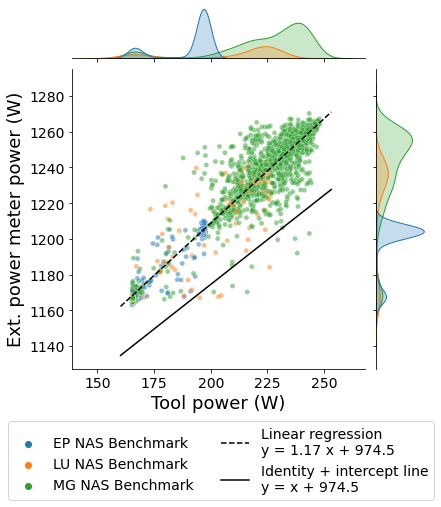

In [12]:
plt.rcParams.update({'font.size': 14})

# Plotting all points by benchmark and regression
grid = sns.jointplot(
    data=result_df_all_solutions, 
    x="tool",
    y='wattmeter',
    hue='benchmark',
    alpha=.5,
    s=25
    )
#grid.plot_joint(sns.scatterplot, s=25, alpha=.6)
grid.set_axis_labels('Tool power (W)', 'Ext. power meter power (W)', fontsize=18)

# Calculating global regression
coef, intercept = calculate_linear_regression(result_df_all_solutions)

# Creating points for linear regression and ploting the regression line
the_x = result_df_all_solutions["tool"].sort_values().values
the_x = np.concatenate([np.array([the_x[0]-5]),the_x, np.array([the_x[-1]+5])])
the_z = coef*the_x + intercept

grid.fig.axes[0].plot(
    the_x,
    the_z, 
    linestyle='--', 
    color='black',
    label=f"Linear regression\ny = {str(round(coef, 2))} x + {str(round(intercept, 1))}",
)

grid.fig.axes[0].plot(
    the_x,
    the_x + round(intercept, 1),
    'k-', 
    label=f"Identity + intercept line\ny = x + {round(intercept, 1)}")

grid.fig.axes[0].legend(
    bbox_to_anchor=(-0.24,-0.15),
    loc='upper left',
    ncol=2
)

grid.savefig('../figures/alltools_correlation_2_no_energy_scope.pdf')
grid.savefig('../figures/alltools_correlation_2_no_energy_scope.png', dpi=100)